### Objective
This notebook runs the following steps:  
  - Read in the input data 
  - Do the train/test splits based on the ACF results 
  - Get the spearman correlation matrix for the training set 
  - Performs clustering (first on indices, second on spearman distance matrix)
  - Pull features for each subcluster and get the new train/test sets

In [1]:
import pandas as pd
import numpy as np
from numpy import random

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.lines import Line2D

from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score

from scipy.cluster.hierarchy import dendrogram
from scipy.stats import spearmanr

from yellowbrick.cluster import KElbowVisualizer
import warnings
warnings.filterwarnings("ignore")

def get_region(id):
    """Given a residue index (integer), return a color associated with the region"""
    id = int(id)
    if id == 186:
        return "green"
    elif id < 75:
        return "gray"
    elif id >= 75 and id < 150:
        return "red"
    elif id >= 150 and id < 250 and id != 186:
        return "blue"
    elif id >= 250:
        return "purple"

def get_region_idx(id):
    """Given a residue index (integer), return an integer associated with the region"""
    id = int(id)
    if id == 186:
        return 2
    elif id < 75:
        return 0
    elif id >= 75 and id < 150:
        return 1
    elif id >= 150 and id < 250 and id != 186:
        return 3
    elif id >= 250:
        return 4
    
def generate_random_color():
    """UNUSED - Generate a random RGB color"""
    r = lambda: random.randint(0,255)
    return '#%02X%02X%02X' % (r(),r(),r())

def inverse(df, last_col_labels=False):
    """
    Inverse the values in a dataframe

    Keyword arguments:
        df -- the dataframe
        last_col_labels -- if True -> last column will not be inversed
    
    Returns:
        df -- the inversed dataframe
    """
    if last_col_labels == True:
        return 1/df.iloc[:,:-1]
    elif last_col_labels == False:
        return 1/df
    
def add_labels(df, nSystem = 4, nFrames = 75000, join=False):
    """
    Add the label column.
    DANGER: I AM ASSUMING THAT WE HAVE FOUR PROTEINS WITH 75000 FRAMES EACH!

    Keyword arguments:
        df -- the dataframe
        join -- if True -> add the label column to the dataframe
               -- if False -> do not add the label column to the dataframe
    
    Returns:
        df3 -- the dataframe after adding the label column
        labels -- label Series
        frameNum -- frame number Series
    """
    
    # Frame numbers to add to the dataframe
    frames = np.arange(0,nFrames,1)
    
    # Bad assumption! Only 4 systems allowed.
    labels = pd.DataFrame(np.concatenate([np.zeros(int(df.shape[0]/nSystem)), np.zeros(int(df.shape[0]/nSystem))+1, np.zeros(int(df.shape[0]/nSystem))+2, np.zeros(int(df.shape[0]/nSystem))+3]), columns=['label'])
    frameNum = pd.DataFrame(np.array([frames]*nSystem).flatten(), columns=['frameNum'])
    
    # If we want to add the columns
    if join == True:
        
        # Join against the label column
        df2 = df.join(labels)
        df2['label'] = df2['label'].astype(int)
        
        # Join against the frame number column
        df3 = df2.join(frameNum)
        df3['frameNum'] = df3['frameNum'].astype(int)
        
    # If we do not want to add the columns, just return the frame number/protein id columns separately
    elif join == False:
        df3 = df
    labels = labels.astype(int)
    frameNum = frameNum.astype(int)
    return df3, labels, frameNum

def plot_metrics(data, min, max, stride, p, outname):
    model = AgglomerativeClustering()

    scores_SS_spearman = []
    
    x = np.arange(min,max,stride)
    for i in x:
        model = AgglomerativeClustering(n_clusters=i)
        y_predict = model.fit_predict(data)
        c = silhouette_score(data, y_predict)
        scores_SS_spearman.append(c)
        
    if p == True:
        fig,ax = plt.subplots(figsize=(5,5),layout='tight')
        ax.plot(x, scores_SS_spearman)
        ax.axvline(np.argmax(scores_SS_spearman)*stride+min, color='red', linestyle='--')
        ax.text(max-min, np.max(scores_SS_spearman),f"{np.argmax(scores_SS_spearman[1:])*stride+min} clusters",horizontalalignment='center',verticalalignment='bottom')
        
        ax.set_ylabel("Silhouette score")
        ax.set_xlabel("# of Clusters")
        plt.savefig(outname,dpi=400)
    return scores_SS_spearman

def plot_metrics_all(data, min, max, stride, outname):
    fig,ax = plt.subplots(1,4, figsize=(30,3),layout='tight')
    model = AgglomerativeClustering()
    elbow = KElbowVisualizer(model, k=np.arange(min, max, stride), metric='distortion', locate_elbow=True,timings=False).fit(data)

    scores_DBI_spearman = []
    scores_CHS_spearman = []
    scores_SS_spearman = []
    
    x = np.arange(min,max,stride)
    for i in x:
        model = AgglomerativeClustering(n_clusters=i)
        y_predict = model.fit_predict(data)
        a = davies_bouldin_score(data, y_predict)
        b = calinski_harabasz_score(data, y_predict)
        c = silhouette_score(data, y_predict)
        scores_DBI_spearman.append(a)
        scores_CHS_spearman.append(b)
        scores_SS_spearman.append(c)

    ax[3].plot(x, elbow.k_scores_)
    ax[3].set_xticks(np.arange(min,max,stride))
    
    ax[0].plot(x, scores_SS_spearman)
    ax[0].axvline(np.argmax(scores_SS_spearman)*stride+min, color='red', linestyle='--')
    ax[0].text(max-min, np.max(scores_SS_spearman),f"{np.argmax(scores_SS_spearman)*stride+min} clusters",horizontalalignment='center',verticalalignment='bottom')
    ax[0].set_xticks(np.arange(min,max,stride))
    ax[1].plot(x, scores_CHS_spearman)
    ax[1].axvline(np.argmax(scores_CHS_spearman)*stride+min, color='red', linestyle='--')
    ax[1].text(max-min, np.max(scores_CHS_spearman),f"{np.argmax(scores_CHS_spearman)*stride+min} clusters",horizontalalignment='center',verticalalignment='bottom')
    ax[1].set_xticks(np.arange(min,max,stride))
    ax[2].plot(x, scores_DBI_spearman)
    ax[2].axvline(np.argmin(scores_DBI_spearman)*stride+min, color='red', linestyle='--')
    ax[2].text(max-min, np.max(scores_DBI_spearman),f"{np.argmin(scores_DBI_spearman)*stride+min} clusters",horizontalalignment='center',verticalalignment='bottom')
    ax[2].set_xticks(np.arange(min,max,stride))
    ax[0].set_ylabel("Silhouette score")
    ax[1].set_ylabel("Calinski Harabasz Score")
    ax[2].set_ylabel("Davies Bouldin score")
    ax[0].set_xlabel("# of Clusters")
    ax[1].set_xlabel("# of Clusters")
    ax[2].set_xlabel("# of Clusters")
    
    plt.savefig(outname,dpi=400)
    return scores_SS_spearman, scores_CHS_spearman, scores_DBI_spearman

def compute_subcluster_model(distance_matrix_spearman, dataset_cluster):
        store_data = []
        subcluster_labels = []
        score = 0
        subcluster_dict = []
        if dataset_cluster.shape[0] >= 4:
            subcluster_spearman = distance_matrix_spearman[dataset_cluster,:][:,dataset_cluster]
            subcluster_labels = dataset.columns[dataset_cluster]
            SS = plot_metrics(subcluster_spearman, 2, len(subcluster_spearman), 1, False, "output/spearman_ideal_6.jpg")
            ideal_clusters = np.argmax(SS) + 2
            subcluster_model = AgglomerativeClustering(n_clusters=ideal_clusters, compute_distances=True)
            subcluster_predict = subcluster_model.fit_predict(subcluster_spearman)
            for index in np.unique(subcluster_predict):
                subcluster_iter = subcluster_labels[np.where(subcluster_predict == index)]
                subcluster_dict.append(np.array(subcluster_iter))
                choice = subcluster_iter[random.choice(range(len(subcluster_iter)))]
                store_data.append(choice)
            score = SS[ideal_clusters]
        elif dataset_cluster.shape[0] < 4 and dataset_cluster.shape[0] > 1:
            ideal_clusters = 1
            score = 1
            subcluster_labels = dataset.columns[dataset_cluster]
            subcluster_dict.append(np.array(subcluster_labels))
            choice = subcluster_labels[random.choice(range(len(subcluster_labels)))]
            store_data.append(choice)
        return subcluster_labels, store_data, score, subcluster_dict

def get_cluster(data, prediction, num):
    return np.where(prediction == num)

def idxlist_to_vmd(arr):
    selstr = "segname PROA and ("
    for i in arr:
        selstr += f"resid {i} or "
    selstr = selstr[:-4] + ")"
    return selstr

colorid = np.array(['dimgray', 'lightgray', 'saddlebrown', 'forestgreen', 'olive', 'purple', 'orangered', 'orange', 'yellow', 'lawngreen', 'darkviolet', 'royalblue', 'crimson', 'aqua', 'deepskyblue', 'blue', 'palevioletred', 'khaki', 'deeppink', 'lightsalmon', 'violet', 'palegreen'])

marker_dict = {
    0: "X",
    1: "o",
    2: "D",
    3: "^",
    4: "s"
}

region_dict = {
    0: "N-TERM",
    1: "H1",
    2: "PAM",
    3: "H2",
    4: "H3"
}

color_dict = {
    0: "gray",
    1: "red",
    2: "green",
    3: "blue",
    4: "purple"
}

PAM_INDEX = 186

# Step 1  - Read data

We read in the complete dataset from step 05. Column names are of the following syntax: `WNTresid_WLSresid`

Call inverse() to get inverse contact distances.

Labels added:<br>
Wnt1A - 0 <br>
Wnt3A - 1 <br>
Wnt5a - 2 <br>
Wnt8a - 3 <br>

In [2]:
nFramesPerSystem = 75000
nSystems = 4

contact = np.array(pd.read_csv(f"../05_combine/output/ML_input.csv")) 
contact_df = pd.read_csv(f"../05_combine/output/ML_input.csv") #Just to get the columns
contact = pd.DataFrame(contact, columns=contact_df.columns)

In [3]:
contact = inverse(contact, last_col_labels=False)
print(f"After reading the data, we have {contact.shape[0]} samples and {contact.shape[1]} features.")
contact, contact_labels, frame_number = add_labels(contact, nSystem=nSystems, nFrames=nFramesPerSystem, join=True)
print(f"After adding labels to the data, we have {contact.shape[0]} samples and {contact.shape[1]} features.")

After reading the data, we have 300000 samples and 985 features.
After adding labels to the data, we have 300000 samples and 987 features.


# Step 2 - ACF Train/Test Split

We will split the data into a train and test set based on the tau value calculated from 06_acf/corr.ipynb.

The test set will contain the frames ranging from 0 - tau.
The train set will contain the frames ranging from 2*tau - nFramesPerSystem.


In [4]:
train_set = pd.DataFrame()
test_set = pd.DataFrame()

# taus = [WNT1 Tau, WNT3a Tau, WNT5a Tau, WNT8a Tau]
# Extracted from 06_acf/corr_acf_t12_numpy.jpg
taus = [16760, 19451, 16689, 16677]

# For each system, 
for i in range(len(taus)):
    test_set = pd.concat([test_set, contact.loc[(nFramesPerSystem*i):(nFramesPerSystem*i) + taus[i] - 1]])
    train_set = pd.concat([train_set, contact.loc[(nFramesPerSystem*i)+(2*taus[i]):(nFramesPerSystem*(i+1))- 1]])

dataset = train_set.iloc[:,:-2] # Dataset without the frame number and system number
print(f"The training data set has {train_set.shape[0]} samples. The test data set has {test_set.shape[0]} samples.")

The training data set has 160846 samples. The test data set has 69577 samples.


# Step 3 -  Spearman Correlation

The spearman correlation matrix is defined using scipy.stats.spearmanr(). We ensure that the matrix is symmetric and define the diagonal as 1 (integer). This is already the case, but sometimes scipy will read 0.9999... instead of 1.

In [5]:
corr = spearmanr(dataset).correlation
corr = (corr + corr.T)/2
np.fill_diagonal(corr,1)

# We convert the correlation matrix to a distance matrix before performing clustering.
distance_matrix_spearman = 1 - np.abs(corr)

## Step 4A - Cluster on Regions

In [6]:
# These are the WNT8a labels from BEFORE we merge down to contacts occurring in all systems
wnt8a_contact_distances_idx = np.loadtxt(f"../04_map/output/WNT8a_threshhold12_labels.txt", dtype=str)

#Split into WNT/WLS indeces
wnt8a_idx = np.array([wnt8a_contact_distances_idx[i].split("_")[0] for i in range(len(wnt8a_contact_distances_idx))]).astype(int)
wntless_idx = np.array([wnt8a_contact_distances_idx[i].split("_")[1] for i in range(len(wnt8a_contact_distances_idx))]).astype(int)
wnt_idx = np.column_stack([wnt8a_idx, wntless_idx])

wnt8a_contact_distances_str = np.array([str(i[0]) + "_" + str(i[1]) for i in wnt_idx])

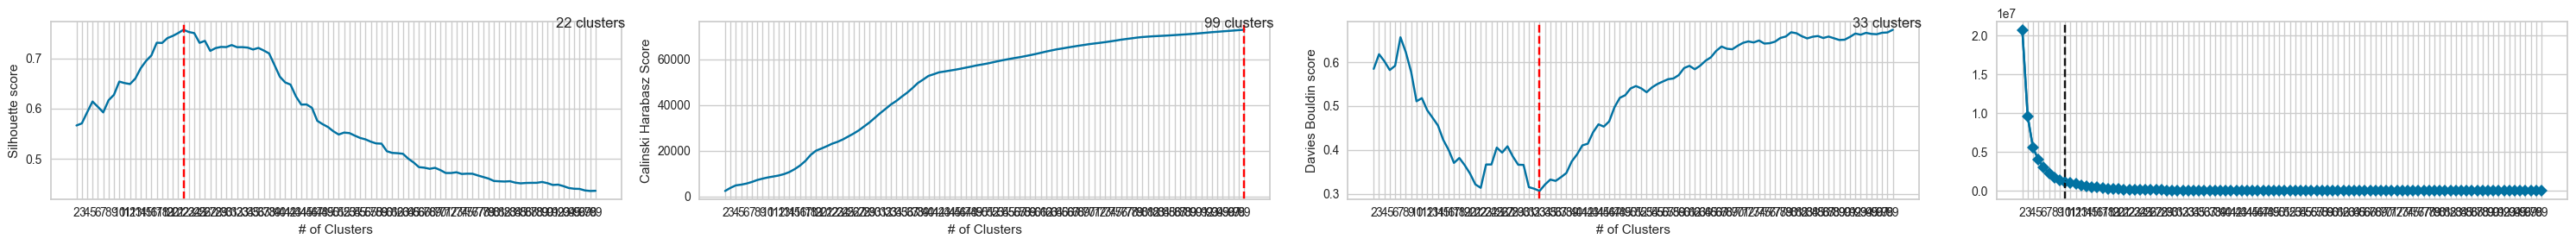

In [7]:
# Plot all of the metrics - we will use the SS score
SS, CHS, DBS =  plot_metrics_all(wnt_idx, 2, 100, 1, "plots/all_clustering_metrics_stage1.jpg")

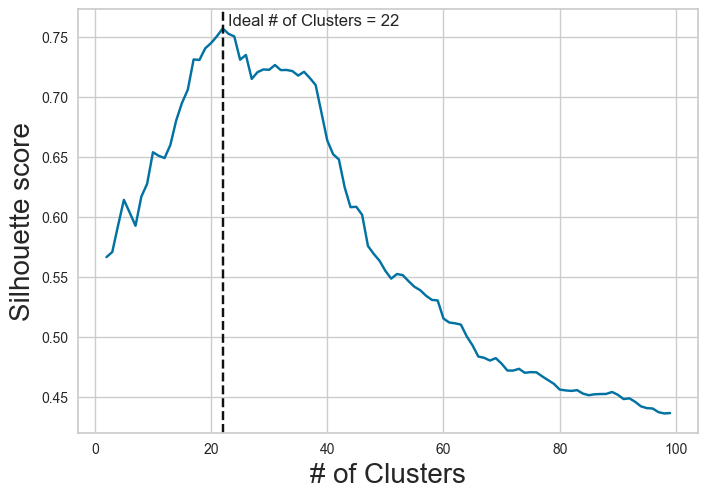

In [8]:
plt.plot(np.arange(2,100,1),SS)
plt.axvline(x=22,linestyle='--',color='k')
plt.text(23,0.76, f"Ideal # of Clusters = 22")
plt.xlabel("# of Clusters", fontsize=20)
plt.ylabel("Silhouette score", fontsize=20)
plt.savefig(f"plots/silhouette_score_stage1.jpg", dpi=400)

In [9]:
# Agglo clustering based on SS Score

clustering = AgglomerativeClustering(n_clusters=22, compute_distances=True)
wnt_predict = clustering.fit_predict(wnt_idx)

# For each datapoint, give it a color and a region
cluster_colors = np.array([colorid[wnt_predict[i]] for i in range(len(wnt_predict))]) # Select colors per cluster
region_colors = np.array([get_region(int(dataset.columns[i].split("_")[0])) for i in range(len(dataset.columns))]) # Region per cluster

markers = []
region = []
region_colors = []

# Assign the regions and the markers - for visualization
for i in range(clustering.n_clusters_):
    current_cluster_idx = np.unique(np.array([i[0] for i in wnt_idx[np.where(wnt_predict == i)]]).astype(int))
    if len(current_cluster_idx) != 0:
        region.append(region_dict[get_region_idx(np.min(current_cluster_idx))])
        if PAM_INDEX not in current_cluster_idx:
            region_colors.append(get_region(np.min(current_cluster_idx)))
            markers.append(marker_dict[get_region_idx(np.min(current_cluster_idx))])
        else:
            region_colors.append(color_dict[get_region_idx(PAM_INDEX)])
            markers.append(marker_dict[get_region_idx(PAM_INDEX)])
    else:
        markers.append("x")
        region.append("x")
        
train_set_clusters = np.zeros(len(dataset.columns))
for point in range(len(dataset.columns)):
    train_set_clusters[point] = wnt_predict[np.where(wnt8a_contact_distances_str == dataset.columns[point])]

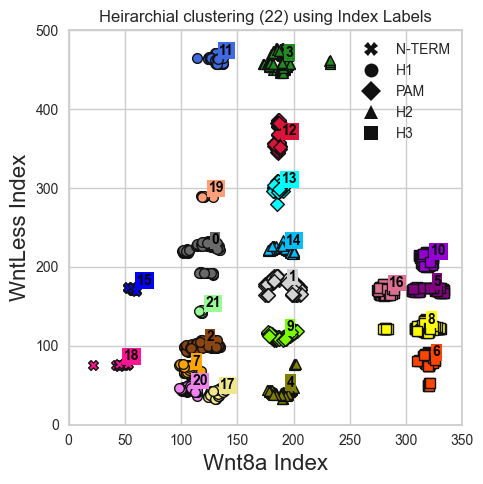

In [10]:
from matplotlib.lines import Line2D
fig, ax1 = plt.subplots(figsize=(5,5))

for i in range(clustering.n_clusters_):
    ax1.scatter(wnt_idx[:,0][np.where(wnt_predict == i)], wnt_idx[:,1][np.where(wnt_predict == i)], color=colorid[i], marker=markers[i], alpha=1, edgecolors='k', linewidths=1)
    ax1.annotate(f"{i}", (np.average(wnt_idx[:,0][np.where(wnt_predict == i)]), np.average(wnt_idx[:,1][np.where(wnt_predict == i)])), fontsize=10, fontweight=1000,color='black', xycoords='data',  xytext=(3,3), textcoords='offset points',bbox=dict(boxstyle="square,pad=0.1", 
                      fc=colorid[i], ec='black', lw=0))
ax1.set_xlim(0,350)
ax1.set_ylim(0,500)
ax1.set_title(f"Heirarchial clustering (22) using Index Labels")
ax1.set_xlabel("Wnt8a Index", fontsize=16)
ax1.set_ylabel("WntLess Index", fontsize=16)
plt.tight_layout()

# create manual symbols for legend
handles, labels = plt.gca().get_legend_handles_labels()
pts = [Line2D([0], [0], label=region_dict[i], marker=marker_dict[i], markersize=10, markeredgecolor='r', markerfacecolor='k', linestyle='') for i in range(5)]
handles.extend(pts)
plt.legend(handles=handles)
plt.savefig("plots/clusterbyindex_stage1.png",dpi=400)


In [11]:
# We want to see what the tSNE plot looks like for the 985 features kept
# keeper = those 985 features we kept

keeper = []
for value in range(len(wnt8a_contact_distances_idx)):
    if wnt8a_contact_distances_idx[value] in dataset.columns:
        keeper.append(value)
        
keeper = np.array(keeper)

In [12]:
wnt8a_contact_distances = np.load(f"../03_finalize_dataset/output/WNT8a_threshhold12_matrix.npy")

# Spearman distance matrix before merging (~2000 features)
corr = spearmanr(wnt8a_contact_distances).correlation
corr = (corr + corr.T)/2
np.fill_diagonal(corr,1)
distance_matrix_spearman_beforemerge = 1 - np.abs(corr)

# Spearman distance matrix after merging (985 features) 
corr = spearmanr(wnt8a_contact_distances).correlation[keeper,:][:,keeper]
corr = (corr + corr.T)/2
np.fill_diagonal(corr,1)
distance_matrix_spearman_aftermerge = 1 - np.abs(corr)

In [13]:
# Keep only the predictions for the features after merging
wnt_predict_new = wnt_predict[keeper]

In [14]:
# tSNE before and after the merge
tsne = TSNE(n_components=2)
tsne_results_beforemerge = tsne.fit_transform(distance_matrix_spearman_beforemerge)
tsne_results_aftermerge = tsne.fit_transform(distance_matrix_spearman_aftermerge)

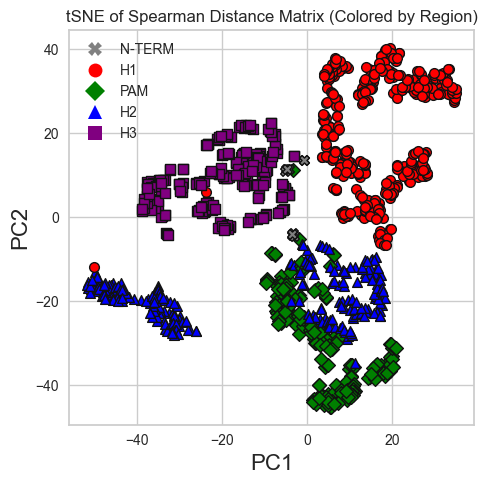

In [15]:
fig,ax1=plt.subplots(figsize=(5,5))
for i in range(clustering.n_clusters_):
    ax1.scatter(tsne_results_aftermerge[np.where(wnt_predict_new == i),0].reshape(-1), tsne_results_aftermerge[np.where(wnt_predict_new == i),1].reshape(-1), color=region_colors[i], marker=markers[i], alpha=1, edgecolors='k', linewidths=1)

ax1.set_title(f"tSNE of Spearman Distance Matrix (Colored by Region)")
ax1.set_xlabel("PC1", fontsize=16)
ax1.set_ylabel("PC2", fontsize=16)
plt.tight_layout()

# create manual symbols for legend
handles, labels = plt.gca().get_legend_handles_labels()
pts = [Line2D([0], [0], label=region_dict[i], marker=marker_dict[i], markersize=10, markeredgecolor='r', markerfacecolor=color_dict[i], linestyle='') for i in range(5)]
handles.extend(pts)
plt.legend(handles=handles)
plt.savefig("plots/clusterbyindex_stage1.png",dpi=400)

In [16]:
cluster_colors = np.array([colorid[wnt_predict_new[i]] for i in range(len(wnt_predict_new))]) # Select colors per cluster
region_colors = np.array([get_region(int(dataset.columns[i].split("_")[0])) for i in range(len(dataset.columns))]) # Region per cluster

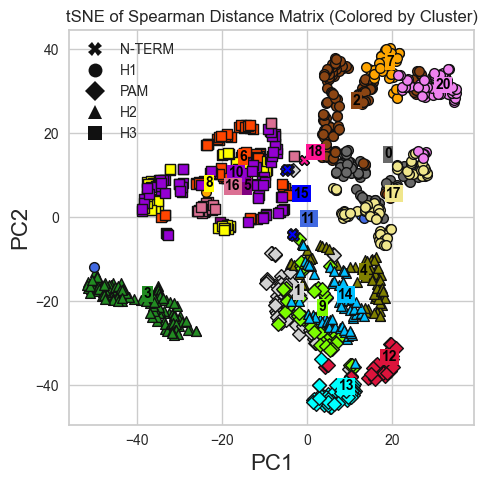

In [17]:
fig,ax1=plt.subplots(figsize=(5,5))
for i in range(clustering.n_clusters_):
    ax1.scatter(tsne_results_aftermerge[np.where(wnt_predict_new == i),0].reshape(-1), tsne_results_aftermerge[np.where(wnt_predict_new == i),1].reshape(-1), color=colorid[i], marker=markers[i], alpha=1, edgecolors='k', linewidths=1)
    ax1.annotate(f"{i}", (np.average(tsne_results_aftermerge[np.where(wnt_predict_new == i),0]), np.average(tsne_results_aftermerge[np.where(wnt_predict_new == i),1])), fontsize=10, fontweight=1000,color='black', xycoords='data',  xytext=(3,3), textcoords='offset points',bbox=dict(boxstyle="square,pad=0.1", fc=colorid[i], ec='black', lw=0))
    
ax1.set_title(f"tSNE of Spearman Distance Matrix (Colored by Cluster)")
ax1.set_xlabel("PC1", fontsize=16)
ax1.set_ylabel("PC2", fontsize=16)
plt.tight_layout()

# create manual symbols for legend
handles, labels = plt.gca().get_legend_handles_labels()
pts = [Line2D([0], [0], label=region_dict[i], marker=marker_dict[i], markersize=10, markeredgecolor='r', markerfacecolor='k', linestyle='') for i in range(5)]
handles.extend(pts)
plt.legend(handles=handles)
plt.savefig("plots/clusterbyindex_stage2.png",dpi=400)


## Step 4B - Subclustering



In [26]:
# There are 22 clusters
ideal_clusters = np.zeros(clustering.n_clusters, dtype=int)
subcluster_contact_labels = []

In [28]:
# Set the random seed to FREEZE results
random.seed(0)

# New dataframe that we will use to store the info from the second level of clustering
df = pd.DataFrame(columns=['clusteridx','nPoints','nSubClusters','SS','selectedSubclusterPoints','ALLsubclusterPoints'])

# For each of the clusters from lvl 1
for i in range(clustering.n_clusters_):
    
    # get all of the points that are in the current cluster (i)
    current_wnt_cluster = wnt_idx[get_cluster(wnt_idx, wnt_predict, i)]
    
    # get all of the indeces of the points that are in the current cluster (i)
    current_wnt_cluster_labels = wnt8a_contact_distances_idx[get_cluster(wnt_idx, wnt_predict, i)]
    
    # For each of the points in the cluster, find that column in the original dataset
    # We need to map the clusters back to the feature idx
    dataset_cluster = np.array([np.where(dataset.columns == curr) for curr in current_wnt_cluster_labels if curr in dataset.columns]).flatten()
    
    # Take all of the points in the subcluster -> dataset_cluster
    # Use that to parse the spearman distance matrix and determine the optimal # of subclusters
    subcluster_labels, store_data, ss_score, ss_dict = compute_subcluster_model(distance_matrix_spearman, dataset_cluster)

    # store in the dataframe
    df.loc[-1] = [i, len(subcluster_labels), len(store_data), ss_score, store_data, ss_dict]
    df.index = df.index + 1
    subcluster_contact_labels.append(store_data)
df.to_pickle("output/clusterbyindex_df.pkl")

In [32]:
subcluster_contact_labels_flattened = np.array([label for subcluster in subcluster_contact_labels for label in subcluster], dtype=str)
subcluster_contact_label_regions = np.array([get_region(int(i.split("_")[0])) for i in subcluster_contact_labels_flattened], dtype=str)

for color in ['red', 'green', 'blue', 'purple', 'gray']:
    np.savetxt(f"output/cluster_region_{color}t.txt", subcluster_contact_labels_flattened[np.where(subcluster_contact_label_regions == color)], fmt='%s')

In [15]:
cols = [np.where(dataset.columns == i)[0][0] for i in subcluster_contact_labels_flattened]
cols.append(-2)
cols.append(-1)

train_set_subcluster = train_set.iloc[:,cols]
test_set_subcluster  = test_set.iloc[:,cols]

In [16]:
train_set_ordered = train_set_subcluster.sort_values(by=['frameNum', 'label'], ascending=True)
print(train_set_ordered.shape)
train_set_ordered.to_csv(f"model/X_train_dt10_4.csv", index=False)

In [ ]:
test_set_ordered = test_set_subcluster.sort_values(by=['frameNum', 'label'], ascending=True)
test_set_ordered.to_csv(f"model/X_test_dt10_4.csv", index=False)